In [13]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Start date
start = '2009-06-10'
## CoinMetrics data
data = pd.read_csv('https://community-api.coinmetrics.io/v2/assets/btc/metricdata.csv?metrics=PriceUSD,CapMrktCurUSD,CapRealUSD,TxTfrValAdjUSD,FeeTotUSD,FeeTotNtv,IssContNtv,BlkCnt,DiffMean,SplyCur,AdrActCnt&start='+start, index_col = 0, parse_dates=True)

## Blockchain.com wallets data
timespan = 'all'
w_data = pd.read_csv('https://api.blockchain.info/charts/my-wallet-n-users?timespan='+timespan+'&format=csv', header=None, infer_datetime_format =True)
w_data.columns = ['Date', 'nWallets']
## Parsing date
w_data['Date'] = w_data['Date'].apply(lambda x: datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
## Eliminate 'intra day' data
w_data['Date'] = w_data['Date'].drop_duplicates(keep = 'last')
w_data = w_data[w_data['Date'].notnull()]
## Date to index
w_data.set_index('Date', inplace=True, drop=True)
## Merge dataframes
data = pd.concat([data, w_data], axis=1, sort=True, join='outer')
## Fill empty cells
data['nWallets'] = data['nWallets'].ffill(axis = 0)

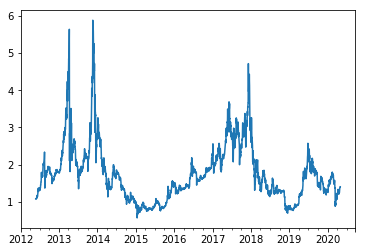

In [20]:
## MVRV

## Realized Price
data['Realized Price'] = data['CapRealUSD'] / data['SplyCur']

## MVRV Ratio
data['MVRV'] = data['CapMrktCurUSD'] / data['CapRealUSD']
## MVRV-z
per = 200
data['MVRV-z'] = (data['MVRV'] - data['MVRV'].rolling(per).mean()) / data['MVRV'].rolling(per).std()

## Price to MVRV (PTM)
data['PTM'] = data['PriceUSD'] * data['MVRV'].mean()

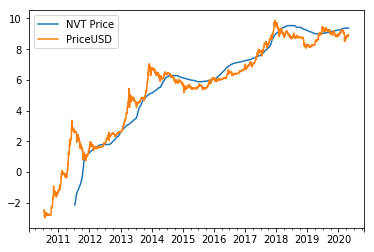

In [15]:
## NVT

## NVT Ratio
data['NVT'] = data['PriceUSD'] / data['TxTfrValAdjUSD']
## NVT Price
per = 360
data['NVT Price'] = (data['NVT'].mean() * data ['TxTfrValAdjUSD']).rolling(per).median()

np.log(data[['NVT Price', 'PriceUSD']]).plot()

In [17]:
## Avoided Costs

## Open csv
avdd_cost = pd.read_csv('Avoided Costs.csv')
avdd_cost.columns = ('Date', 'AC Price')
## Fix index
avdd_cost.set_index('Date', inplace=True)
avdd_cost.index = pd.to_datetime(avdd_cost.index)
## Join DataFrame
data = data.join(avdd_cost)

ValueError: columns overlap but no suffix specified: Index(['AC Price'], dtype='object')

In [18]:
## Cost of Production

## Open csv
cost_prod = pd.read_csv('Data/Edwards model.csv')
## Fix index
cost_prod.set_index('Date', inplace=True)
cost_prod.index = pd.to_datetime(cost_prod.index)
## Join DataFrame
data = data.join(cost_prod)
## Fix Name
data['Cost of Production'] = data['Bitcoin Energy Value ($/BTC)']
data.drop(['Bitcoin Energy Value ($/BTC)'], axis =1)



,PriceUSD,CapMrktCurUSD,CapRealUSD,TxTfrValAdjUSD,FeeTotUSD,FeeTotNtv,IssContNtv,BlkCnt,DiffMean,SplyCur,AdrActCnt,nWallets,Realized Price,MVRV,MVRV-z,PTM,NVT,NVT Price,AC Price,Cost of Production
2009-06-10,NaN,NaN,0.000000e+00,NaN,NaN,0.000000,4100.0,82.0,1.000000e+00,8.433500e+05,82.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000074
2009-06-11,NaN,NaN,0.000000e+00,NaN,NaN,0.000000,4450.0,89.0,1.000000e+00,8.478000e+05,89.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000094
2009-06-12,NaN,NaN,0.000000e+00,NaN,NaN,0.000000,4300.0,86.0,1.000000e+00,8.521000e+05,86.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000094
2009-06-13,NaN,NaN,0.000000e+00,NaN,NaN,0.000000,3900.0,78.0,1.000000e+00,8.560000e+05,78.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000094
2009-06-14,NaN,NaN,0.000000e+00,NaN,NaN,0.000000,3600.0,72.0,1.000000e+00,8.596000e+05,72.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000082
2009-06-15,NaN,NaN,0.000000e+00,NaN,NaN,0.000000,4200.0,84.0,1.000000e+00,8.638000e+05,84.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000082
2009-06-16,NaN,NaN,0.000000e+00,NaN,NaN,0.000000,3550.0,71.0,1.000000e+00,8.673500e+05,71.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000082
2009-06-17,NaN,NaN,0.000000e+00,NaN,NaN,0.000000,3950.0,79.0,1.000000e+00,8.713000e+05,79.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000096
2009-06-18,NaN,NaN,0.000000e+00,NaN,NaN,0.000000,4000.0,80.0,1.000000e+00,8.753000e+05,80.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000096
2009-06-19,NaN,NaN,0.000000e+00,NaN,NaN,0.000000,4350.0,87.0,1.000000e+00,8.796500e+05,87.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000096


S2F Price = 3.24 * log(S2F) + -1.65
r2 = 0.94


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


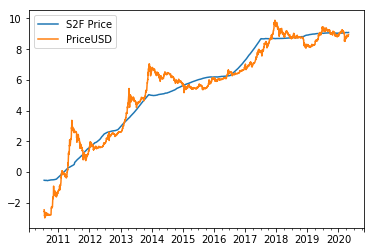

In [8]:
## Stock-to-Flow

## S2F Ratio
data['S2F'] = data['SplyCur'] / data['IssContNtv'].rolling(360).sum()

w_data = data[['S2F', 'PriceUSD']]
w_data.dropna(thresh = 2, inplace=True)

log_s2f = np.log(w_data['S2F']).values.reshape(-1, 1)
log_price = np.log(w_data['PriceUSD']).values.reshape(-1, 1)

reg = LinearRegression().fit(log_s2f, log_price)

a = reg.coef_[0][0]
b = reg.intercept_[0]

data['S2F Price'] = np.exp(np.log(w_data['S2F']) * a + b)

r2 = reg.score(log_s2f, log_price)

print('S2F Price = '+str(a.round(2))+' * log(S2F) + '+str(b.round(2)))
print('r2 = '+str(r2.round(2)))
np.log(data[['S2F Price', 'PriceUSD']]).plot()

In [9]:
## Metcalfe's Law

## Cost of Production

## Open csv
metcalfe = pd.read_csv('Data/Metcalfe.csv')
metcalfe.columns = ('Date', 'DAA Metcalfe Price', 'Metcalfe Price')

## Fix index
metcalfe.set_index('Date', inplace=True)
metcalfe.index = pd.to_datetime(metcalfe.index)

## Join DataFrame
data = data.join(metcalfe)

In [10]:
## Create .csv file

data = data[['PriceUSD', 'Realized Price', 'NVT Price', 'AC Price', 'Cost of Production', 'Metcalfe Price', 'S2F Price']]
## Translate to Portuguese
data.columns = [['Preço', 'Preço Realizado', 'Preço de NVT', 'Custos Evitados', 'Custo de Produção', 'Preço de Metcalfe', 'Preço de Estoque-Fluxo']]
## Drop NaN
data.dropna(thresh = 7, inplace = True)
## Save as .csv
data.to_csv('metrics.csv')

In [11]:
data

,Preço,Preço Realizado,Preço de NVT,Custos Evitados,Custo de Produção,Preço de Metcalfe,Preço de Estoque-Fluxo
2011-11-29,2.757698,4.889777,2.804262,3.540148,15.0,4.494576,4.263192
2011-11-30,2.966042,4.905103,2.870894,3.563358,15.0,4.494576,4.295555
2011-12-01,3.082589,4.910057,2.977047,3.589234,14.0,4.494576,4.325735
2011-12-02,3.100402,4.909299,3.026217,3.625762,14.0,4.494576,4.360933
2011-12-03,2.803856,4.885003,3.038369,3.666433,14.0,4.494576,4.395307
2011-12-04,2.819694,4.883833,3.049650,3.713462,12.0,4.494576,4.428740
2011-12-05,2.874796,4.880742,3.097325,3.758743,12.0,4.494576,4.440617
2011-12-06,3.025360,4.886569,3.142987,3.785328,12.0,4.494576,4.457364
2011-12-07,2.985502,4.856501,3.191744,3.805547,15.0,4.494576,4.478195
2011-12-08,2.991880,4.856528,3.240838,3.836777,15.0,4.494576,4.487772
